In [1]:
import functools
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.spatial.distance import cdist
import torch
import torch.nn.functional as F
from torch import optim
import pickle
from symfac.experimental import RBFExpansionV2
from symfac.experimental import RBFExpansionMiniBatch
import timeit
import matplotlib.pyplot as plt

In [2]:
d_tensor = torch.load('data/paper/d1')

In [3]:
d_tensor.shape

torch.Size([256, 256])

In [4]:
target = torch.tensor(d_tensor, dtype=torch.float)

<ipython-input-4-1f4127bc6c9b>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(d_tensor, dtype=torch.float)


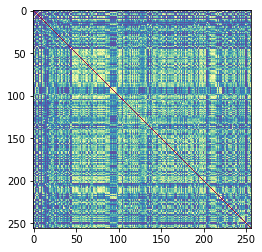

In [6]:
plt.imshow(target, cmap='Spectral')

In [7]:
bs = 100
N = 256

100%|██████████| 10000/10000 [00:40<00:00, 244.61it/s]


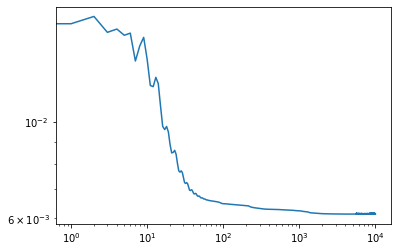

0.0061358


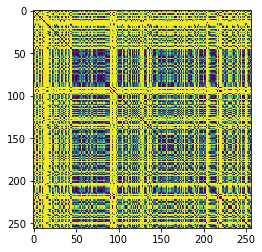

100%|██████████| 20000/20000 [02:32<00:00, 131.56it/s]


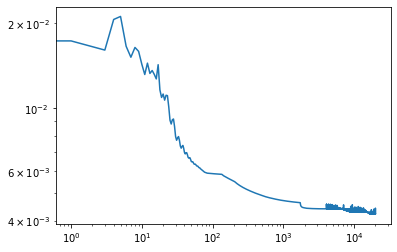

0.004226


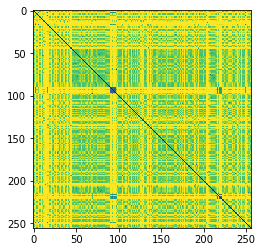

100%|██████████| 30000/30000 [05:49<00:00, 85.95it/s]


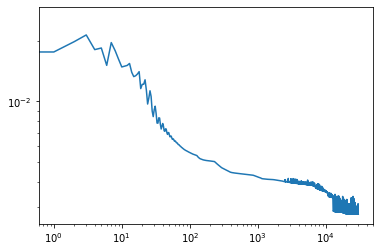

0.0027636


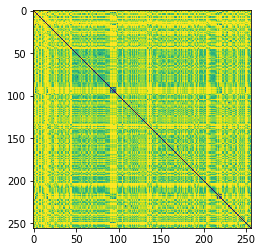

100%|██████████| 40000/40000 [08:41<00:00, 76.66it/s]


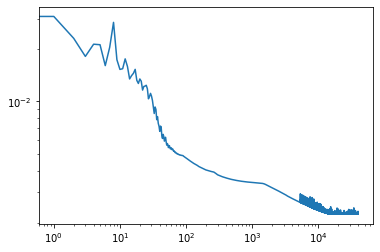

0.0022452


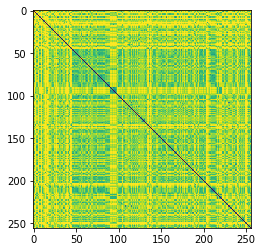

100%|██████████| 50000/50000 [14:31<00:00, 57.34it/s]


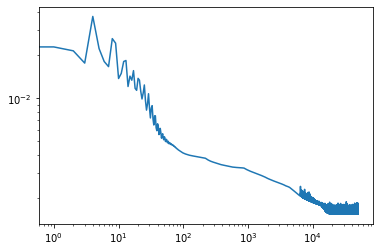

0.0015363


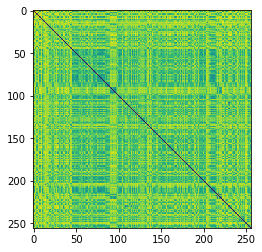

100%|██████████| 60000/60000 [19:28<00:00, 51.36it/s]


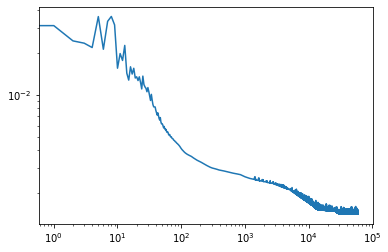

0.0014056


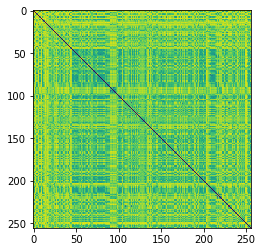

100%|██████████| 70000/70000 [27:50<00:00, 41.90it/s]


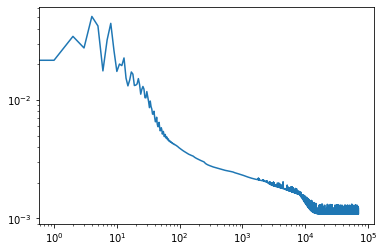

0.001082


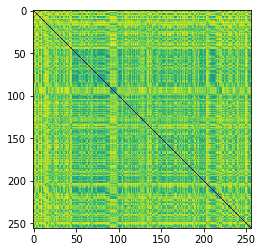

 77%|███████▋  | 61637/80000 [24:46<07:22, 41.47it/s]


KeyboardInterrupt: 

In [51]:
errors = []
times = []
for k in range(1,11):
    num_iters = k*10000
    start = timeit.timeit()
    u0=1/10*torch.randn([bs, len(target), k], device="cuda") 
    a=torch.randn([bs, k], device="cuda")
    b=torch.randn([bs], device="cuda")
    fac = RBFExpansionV2(k=k, batch_size=bs, max_steps=num_iters)
    fac.fith(
        target,
        u0=u0,
        a0=a,
        b0=b
    )
    plt.loglog(
    fac.report.loss_history_ticks,
    fac.report.loss_history.min(axis=1)
    )
    plt.show()

    plt.show()
    error = fac.report.loss_best
    er = round(float(torch.min(error).cpu().detach().numpy()), 7)
    print(er)
    errors.append(er)
    end = timeit.timeit()
    times.append(end - start)
    plt.imshow(fac.optimum(runs=torch.argmin(fac.report.loss_best)))
    plt.show()
print(errors)


100%|██████████| 80000/80000 [31:35<00:00, 42.21it/s]


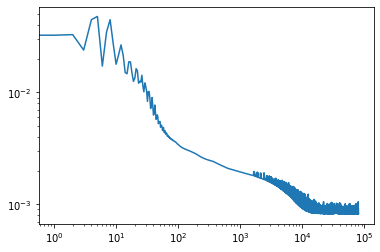

0.0008162


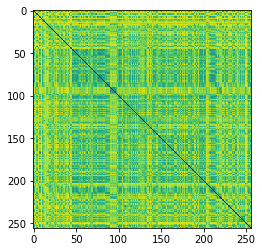

100%|██████████| 90000/90000 [45:29<00:00, 32.97it/s]


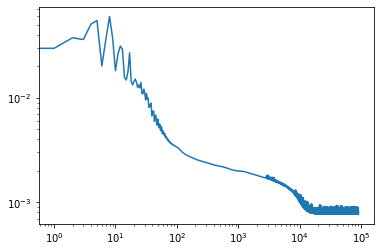

0.0007716


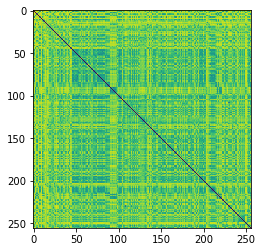

100%|██████████| 100000/100000 [53:50<00:00, 30.96it/s]


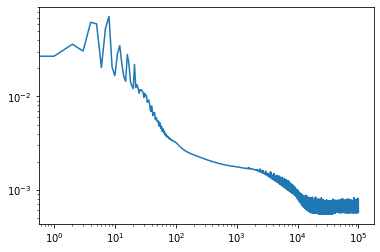

0.0005482


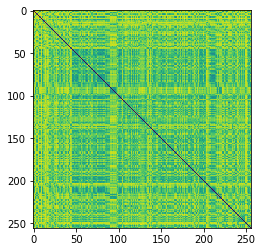

[0.0008162, 0.0007716, 0.0005482]


In [79]:
errors2 = []
times = []
for k in range(8,11):
    num_iters = k*10000
    start = timeit.timeit()
    u0=1/10*torch.randn([bs, len(target), k], device="cuda") 
    a=torch.randn([bs, k], device="cuda")
    b=torch.randn([bs], device="cuda")
    fac = RBFExpansionV2(k=k, batch_size=bs, max_steps=num_iters)
    fac.fith(
        target,
        u0=u0,
        a0=a,
        b0=b
    )
    plt.loglog(
    fac.report.loss_history_ticks,
    fac.report.loss_history.min(axis=1)
    )
    plt.show()

    plt.show()
    error = fac.report.loss_best
    er = round(float(torch.min(error).cpu().detach().numpy()), 7)
    print(er)
    errors2.append(er)
    end = timeit.timeit()
    times.append(end - start)
    plt.imshow(fac.optimum(runs=torch.argmin(fac.report.loss_best)))
    plt.show()
print(errors2)


In [81]:
errors 

[0.0061358, 0.004226, 0.0027636, 0.0022452, 0.0015363, 0.0014056, 0.001082]

In [82]:
errors2

[0.0008162, 0.0007716, 0.0005482]

In [83]:
gd_10_losses = errors + errors2

In [93]:
gd_10_times = [40/60, (2*60+32)/60, (5*60+49)/60, (8*60+41)/60, (14*60+31)/60, (19*60+28)/60, (27*60+50)/60, (31*60+35)/60, (45*60+29)/60, (53*60+50)/60]

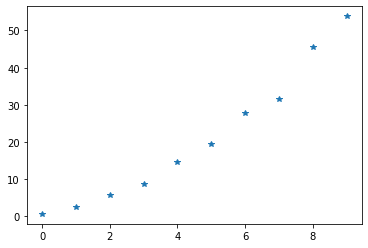

In [96]:
plt.plot(gd_10_times, '*')

In [97]:
open('gd_10.pickle', 'wb').write(pickle.dumps([gd_10_losses, gd_10_times]))

204

  0%|          | 0/100000 [00:00<?, ?it/s]

10


100%|██████████| 100000/100000 [23:15<00:00, 71.65it/s]


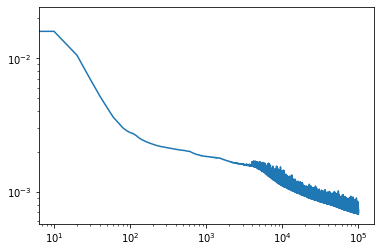

0.0006806


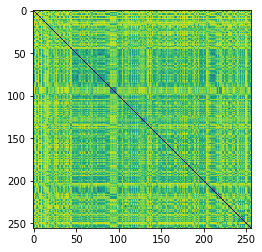

[0.0006806]


In [105]:
errorsmini = []
for k in range(10,9,-1):
    print(k)
    num_iters = k*10000
    u0=1/10*torch.randn([bs, target.shape[0], k], device="cuda") 
    a=torch.randn([bs, k], device="cuda")
    b=torch.randn([bs], device="cuda")
    fac_mini = RBFExpansionMiniBatch(k=k, mini_batch_size= 5 * k * target.shape[0], batch_size=bs, max_steps=num_iters, mini_batch_by='elements')
    

    fac_mini.fit_custom(
        target,
        f=lambda u, a, b:
            torch.sum(
                fac_mini.rbf(u[..., :, None, :] - u[..., None, :, :]) *
                a[..., None, None, :],
                dim=-1
            ) + b[..., None, None],
        f_minibatch=lambda i, j, u, a, b:
            torch.sum(
                fac_mini.rbf(u[..., i, :] - u[..., j, :]) * a[..., None, :],
            dim=-1
        ) + b[..., None],
        seed=0,
        u=0.001 * fac_mini.randn(fac_mini.batch_size, target.shape[0], fac_mini.k),
        a=fac_mini.randn(fac_mini.batch_size, fac_mini.k),
        b=fac_mini.randn(fac_mini.batch_size)
)
    plt.loglog(
    fac_mini.report.loss_history_ticks,
    fac_mini.report.loss_history.min(axis=1)
    )
    plt.show()

    plt.show()
    error = fac_mini.report.loss_best
    er = round(float(torch.min(error).cpu().detach().numpy()), 7)
    print(er)
    errorsmini.append(er)
    plt.imshow( fac_mini.optimum(runs=torch.argmin( fac_mini.report.loss_best)))
    plt.show()
print(errorsmini)



In [103]:
sgd_10_losses = errorsmini[::-1]

In [107]:
sgd_10_losses[-1] = 0.0006806

In [108]:
sgd_10_times = [21/60, (0*60+52)/60, (1*60+41)/60, (2*60+56)/60, (4*60+50)/60, (7*60+3)/60, (10*60+1)/60, (13*60+26)/60, (18*60+14)/60, (23*60+15)/60]

In [109]:
open('sgd_10.pickle', 'wb').write(pickle.dumps([sgd_10_losses, sgd_10_times]))

204

  0%|          | 0/50000 [00:00<?, ?it/s]

128


100%|██████████| 50000/50000 [12:02<00:00, 69.19it/s]


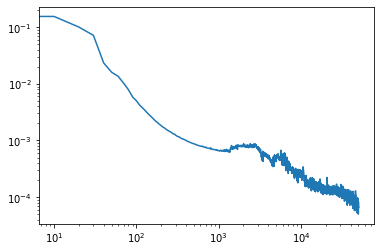

5e-05


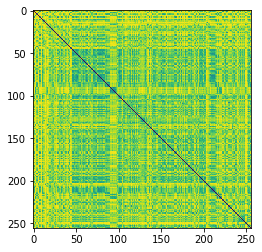

[5e-05]


In [13]:
torch.manual_seed(15513512)

bs = 50
errorsmaxi = []
for k in [128]:
    print(k)
    num_iters = 50000
    u0=1/10*torch.randn([bs, target.shape[0], k], device="cuda") 
    a=torch.randn([bs, k], device="cuda")
    b=torch.randn([bs], device="cuda")
    fac_maxi = RBFExpansionMiniBatch(k=k, mini_batch_size= 8 * target.shape[0], batch_size=bs, max_steps=num_iters, mini_batch_by='elements')
    

    fac_maxi.fit_custom(
        target,
        f=lambda u, a, b:
            torch.sum(
                fac_maxi.rbf(u[..., :, None, :] - u[..., None, :, :]) *
                a[..., None, None, :],
                dim=-1
            ) + b[..., None, None],
        f_minibatch=lambda i, j, u, a, b:
            torch.sum(
                fac_maxi.rbf(u[..., i, :] - u[..., j, :]) * a[..., None, :],
            dim=-1
        ) + b[..., None],
        seed=0,
        u=0.01 * fac_maxi.randn(fac_maxi.batch_size, target.shape[0], fac_maxi.k),
        a=fac_maxi.randn(fac_maxi.batch_size, fac_maxi.k),
        b=fac_maxi.randn(fac_maxi.batch_size)
)
    plt.loglog(
    fac_maxi.report.loss_history_ticks,
    fac_maxi.report.loss_history.min(axis=1)
    )
    plt.show()

    plt.show()
    error = fac_maxi.report.loss_best
    er = round(float(torch.min(error).cpu().detach().numpy()), 7)
    print(er)
    errorsmaxi.append(er)
    plt.imshow( fac_maxi.optimum(runs=torch.argmin( fac_maxi.report.loss_best)))
    plt.show()
print(errorsmaxi)


In [ ]:
sgd_long_times = []

128


100%|██████████| 50000/50000 [12:23<00:00, 67.22it/s]


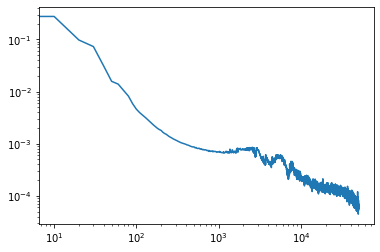

4.47e-05


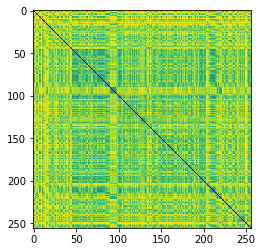

[0.0061504, 0.0041449, 0.0023808, 0.0012769, 0.0005753, 0.0002058, 7.15e-05, 4.47e-05]


In [8]:
#torch.manual_seed(15513512)
#torch.manual_seed(15513513)
#torch.manual_seed(15514514)
#torch.manual_seed(15515515)
torch.manual_seed(16)

#errorsmaxi16=[]
bs = 50
for k in [128]:
    print(k)
    num_iters = 50000
    u0=1/10*torch.randn([bs, target.shape[0], k], device="cuda") 
    a=torch.randn([bs, k], device="cuda")
    b=torch.randn([bs], device="cuda")
    fac_maxi = RBFExpansionMiniBatch(k=k, mini_batch_size= 8 * target.shape[0], batch_size=bs, max_steps=num_iters, mini_batch_by='elements')
    

    fac_maxi.fit_custom(
        target,
        f=lambda u, a, b:
            torch.sum(
                fac_maxi.rbf(u[..., :, None, :] - u[..., None, :, :]) *
                a[..., None, None, :],
                dim=-1
            ) + b[..., None, None],
        f_minibatch=lambda i, j, u, a, b:
            torch.sum(
                fac_maxi.rbf(u[..., i, :] - u[..., j, :]) * a[..., None, :],
            dim=-1
        ) + b[..., None],
        seed=0,
        u=0.01 * fac_maxi.randn(fac_maxi.batch_size, target.shape[0], fac_maxi.k),
        a=fac_maxi.randn(fac_maxi.batch_size, fac_maxi.k),
        b=fac_maxi.randn(fac_maxi.batch_size)
)
    plt.loglog(
    fac_maxi.report.loss_history_ticks,
    fac_maxi.report.loss_history.min(axis=1)
    )
    plt.show()

    plt.show()
    error = fac_maxi.report.loss_best
    er = round(float(torch.min(error).cpu().detach().numpy()), 7)
    print(er)
    errorsmaxi16.append(er)
    plt.imshow( fac_maxi.optimum(runs=torch.argmin( fac_maxi.report.loss_best)))
    plt.show()
print(errorsmaxi16)


In [15]:
open('sgd_long.pickle', 'wb').write(pickle.dumps([errorsmaxi[::-1], [(2*60+39)/60, (4*60+41)/60, (7*60+45)/60, (12*60+2)/60]]))

96

In [31]:
open('sgd_full_13.pickle', 'wb').write(pickle.dumps(errorsmaxi13))

88

In [7]:
open('sgd_full_14.pickle', 'wb').write(pickle.dumps(errorsmaxi14))

88

In [9]:
open('sgd_full_15.pickle', 'wb').write(pickle.dumps(errorsmaxi15))

88

In [10]:
open('sgd_full_16.pickle', 'wb').write(pickle.dumps(errorsmaxi16))

88

In [26]:
open('sgd_full.pickle', 'wb').write(pickle.dumps(errorsmaxi[4:]))

88

In [9]:
errorsmaxi16

[0.0061504,
 0.0041449,
 0.0023808,
 0.0012769,
 0.0005753,
 0.0002058,
 7.15e-05,
 4.47e-05]

# ----------------------------

  0%|          | 0/10000 [00:00<?, ?it/s]

1


100%|██████████| 10000/10000 [00:25<00:00, 391.07it/s]


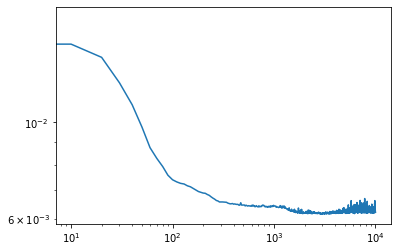

0.0061555


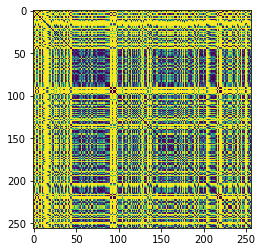

[0.0061555]


In [59]:
for k in range(1,2):
    print(k)
    num_iters = 10000
    u0=1/10*torch.randn([bs, target.shape[0], k], device="cuda") 
    a=torch.randn([bs, k], device="cuda")
    b=torch.randn([bs], device="cuda")
    fac_mini = RBFExpansionMiniBatch(k=k, mini_batch_size= 3 * k * target.shape[0], batch_size=bs, max_steps=num_iters, mini_batch_by='elements')
    

    fac_mini.fit_custom(
        target,
        f=lambda u, a, b:
            torch.sum(
                fac_mini.rbf(u[..., :, None, :] - u[..., None, :, :]) *
                a[..., None, None, :],
                dim=-1
            ) + b[..., None, None],
        f_minibatch=lambda i, j, u, a, b:
            torch.sum(
                fac_mini.rbf(u[..., i, :] - u[..., j, :]) * a[..., None, :],
            dim=-1
        ) + b[..., None],
        seed=0,
        u=0.001 * fac_mini.randn(fac_mini.batch_size, target.shape[0], fac_mini.k),
        a=fac_mini.randn(fac_mini.batch_size, fac_mini.k),
        b=fac_mini.randn(fac_mini.batch_size)
)
    plt.loglog(
    fac_mini.report.loss_history_ticks,
    fac_mini.report.loss_history.min(axis=1)
    )
    plt.show()

    plt.show()
    error = fac_mini.report.loss_best
    er = round(float(torch.min(error).cpu().detach().numpy()), 7)
    print(er)
    errors_mini_2.append(er)
    plt.imshow( fac_mini.optimum(runs=torch.argmin( fac_mini.report.loss_best)))
    plt.show()
    open('fac_mini_kernel_{0}.pickle'.format(k), 'wb').write(pickle.dumps(fac_mini.optimum.x))
print(errors_mini_2)



  0%|          | 0/20000 [00:00<?, ?it/s]

2


100%|██████████| 20000/20000 [00:48<00:00, 409.59it/s]


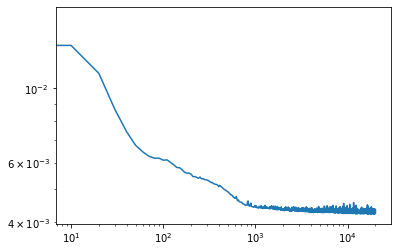

0.0042238


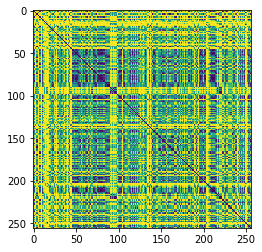

[0.0061555, 0.0042238]


In [60]:
for k in range(2,3):
#for k in [20,40,60,80,100,120,140,160,180,200,220,240]:
    print(k)
    num_iters = 20000
    u0=1/10*torch.randn([bs, target.shape[0], k], device="cuda") 
    a=torch.randn([bs, k], device="cuda")
    b=torch.randn([bs], device="cuda")
    fac_mini = RBFExpansionMiniBatch(k=k, mini_batch_size= 3 * k * target.shape[0], batch_size=bs, max_steps=num_iters, mini_batch_by='elements')
    

    fac_mini.fit_custom(
        target,
        f=lambda u, a, b:
            torch.sum(
                fac_mini.rbf(u[..., :, None, :] - u[..., None, :, :]) *
                a[..., None, None, :],
                dim=-1
            ) + b[..., None, None],
        f_minibatch=lambda i, j, u, a, b:
            torch.sum(
                fac_mini.rbf(u[..., i, :] - u[..., j, :]) * a[..., None, :],
            dim=-1
        ) + b[..., None],
        seed=0,
        u=0.001 * fac_mini.randn(fac_mini.batch_size, target.shape[0], fac_mini.k),
        a=fac_mini.randn(fac_mini.batch_size, fac_mini.k),
        b=fac_mini.randn(fac_mini.batch_size)
)
    plt.loglog(
    fac_mini.report.loss_history_ticks,
    fac_mini.report.loss_history.min(axis=1)
    )
    plt.show()

    plt.show()
    error = fac_mini.report.loss_best
    er = round(float(torch.min(error).cpu().detach().numpy()), 7)
    print(er)
    errors_mini_2.append(er)
    plt.imshow( fac_mini.optimum(runs=torch.argmin( fac_mini.report.loss_best)))
    plt.show()
    open('fac_mini_kernel_{0}.pickle'.format(k), 'wb').write(pickle.dumps(fac_mini.optimum.x))
print(errors_mini_2)


  0%|          | 0/50000 [00:00<?, ?it/s]

3


100%|██████████| 50000/50000 [03:46<00:00, 221.03it/s]


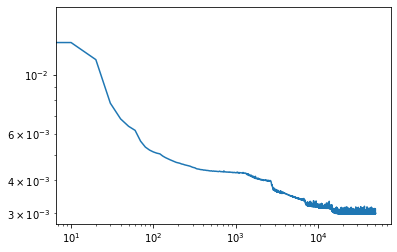

0.0029828


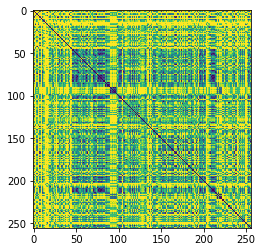

[0.0061555, 0.0042238, 0.0031869, 0.0030221, 0.003059, 0.0031046, 0.003088, 0.0031571, 0.003109, 0.0029828]


In [70]:
torch.manual_seed(15513512)

bs = 100
for k in range(3,4):
#for k in [20,40,60,80,100,120,140,160,180,200,220,240]:
    print(k)
    num_iters = 50000
    u0=1/10*torch.randn([bs, target.shape[0], k], device="cuda") 
    a=torch.randn([bs, k], device="cuda")
    b=torch.randn([bs], device="cuda")
    fac_mini = RBFExpansionMiniBatch(k=k, mini_batch_size= 24 * target.shape[0], batch_size=bs, max_steps=num_iters, mini_batch_by='elements')
    

    fac_mini.fit_custom(
        target,
        f=lambda u, a, b:
            torch.sum(
                fac_mini.rbf(u[..., :, None, :] - u[..., None, :, :]) *
                a[..., None, None, :],
                dim=-1
            ) + b[..., None, None],
        f_minibatch=lambda i, j, u, a, b:
            torch.sum(
                fac_mini.rbf(u[..., i, :] - u[..., j, :]) * a[..., None, :],
            dim=-1
        ) + b[..., None],
        seed=0,
        u=0.001 * fac_mini.randn(fac_mini.batch_size, target.shape[0], fac_mini.k),
        a=fac_mini.randn(fac_mini.batch_size, fac_mini.k),
        b=fac_mini.randn(fac_mini.batch_size)
)
    plt.loglog(
    fac_mini.report.loss_history_ticks,
    fac_mini.report.loss_history.min(axis=1)
    )
    plt.show()

    plt.show()
    error = fac_mini.report.loss_best
    er = round(float(torch.min(error).cpu().detach().numpy()), 7)
    print(er)
    errors_mini_2.append(er)
    plt.imshow( fac_mini.optimum(runs=torch.argmin( fac_mini.report.loss_best)))
    plt.show()
    open('fac_mini_kernel_{0}.pickle'.format(k), 'wb').write(pickle.dumps(fac_mini.optimum.x))
print(errors_mini_2)


  0%|          | 0/50000 [00:00<?, ?it/s]

4


100%|██████████| 50000/50000 [07:19<00:00, 113.73it/s]


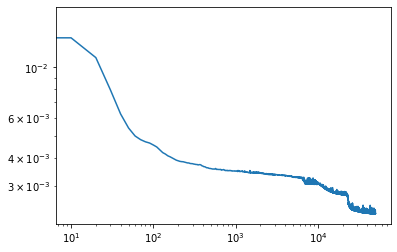

0.0022538


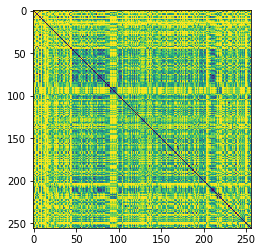

[0.0061555, 0.0042238, 0.0031869, 0.0030221, 0.003059, 0.0031046, 0.003088, 0.0031571, 0.003109, 0.0029828, 0.0027228, 0.0026649, 0.0022538]


In [74]:
torch.manual_seed(15513512)

bs = 100
for k in range(4,5):
#for k in [20,40,60,80,100,120,140,160,180,200,220,240]:
    print(k)
    num_iters = 50000
    u0=1/10*torch.randn([bs, target.shape[0], k], device="cuda") 
    a=torch.randn([bs, k], device="cuda")
    b=torch.randn([bs], device="cuda")
    fac_mini = RBFExpansionMiniBatch(k=k, mini_batch_size= 48 * target.shape[0], batch_size=bs, max_steps=num_iters, mini_batch_by='elements')
    

    fac_mini.fit_custom(
        target,
        f=lambda u, a, b:
            torch.sum(
                fac_mini.rbf(u[..., :, None, :] - u[..., None, :, :]) *
                a[..., None, None, :],
                dim=-1
            ) + b[..., None, None],
        f_minibatch=lambda i, j, u, a, b:
            torch.sum(
                fac_mini.rbf(u[..., i, :] - u[..., j, :]) * a[..., None, :],
            dim=-1
        ) + b[..., None],
        seed=0,
        u=0.001 * fac_mini.randn(fac_mini.batch_size, target.shape[0], fac_mini.k),
        a=fac_mini.randn(fac_mini.batch_size, fac_mini.k),
        b=fac_mini.randn(fac_mini.batch_size)
)
    plt.loglog(
    fac_mini.report.loss_history_ticks,
    fac_mini.report.loss_history.min(axis=1)
    )
    plt.show()

    plt.show()
    error = fac_mini.report.loss_best
    er = round(float(torch.min(error).cpu().detach().numpy()), 7)
    print(er)
    errors_mini_2.append(er)
    plt.imshow( fac_mini.optimum(runs=torch.argmin( fac_mini.report.loss_best)))
    plt.show()
    open('fac_mini_kernel_{0}.pickle'.format(k), 'wb').write(pickle.dumps(fac_mini.optimum.x))
print(errors_mini_2)


  0%|          | 0/70000 [00:00<?, ?it/s]

5


100%|██████████| 70000/70000 [10:49<00:00, 107.84it/s]


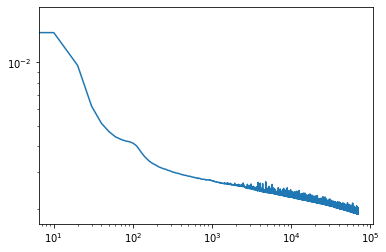

0.0018908


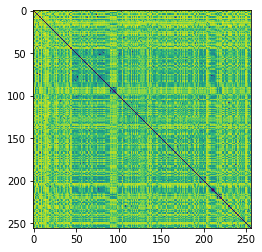

[0.0061555, 0.0042238, 0.0031869, 0.0030221, 0.003059, 0.0031046, 0.003088, 0.0031571, 0.003109, 0.0029828, 0.0027228, 0.0026649, 0.0022538, 0.0019669, 0.0019885, 0.0018908]


In [77]:
torch.manual_seed(15513512)

bs = 100
for k in range(5,6):
#for k in [20,40,60,80,100,120,140,160,180,200,220,240]:
    print(k)
    num_iters = 70000
    u0=1/10*torch.randn([bs, target.shape[0], k], device="cuda") 
    a=torch.randn([bs, k], device="cuda")
    b=torch.randn([bs], device="cuda")
    fac_mini = RBFExpansionMiniBatch(k=k, mini_batch_size= 48 * target.shape[0], batch_size=bs, max_steps=num_iters, mini_batch_by='elements')
    

    fac_mini.fit_custom(
        target,
        f=lambda u, a, b:
            torch.sum(
                fac_mini.rbf(u[..., :, None, :] - u[..., None, :, :]) *
                a[..., None, None, :],
                dim=-1
            ) + b[..., None, None],
        f_minibatch=lambda i, j, u, a, b:
            torch.sum(
                fac_mini.rbf(u[..., i, :] - u[..., j, :]) * a[..., None, :],
            dim=-1
        ) + b[..., None],
        seed=0,
        u=0.001 * fac_mini.randn(fac_mini.batch_size, target.shape[0], fac_mini.k),
        a=fac_mini.randn(fac_mini.batch_size, fac_mini.k),
        b=fac_mini.randn(fac_mini.batch_size)
)
    plt.loglog(
    fac_mini.report.loss_history_ticks,
    fac_mini.report.loss_history.min(axis=1)
    )
    plt.show()

    plt.show()
    error = fac_mini.report.loss_best
    er = round(float(torch.min(error).cpu().detach().numpy()), 7)
    print(er)
    errors_mini_2.append(er)
    plt.imshow( fac_mini.optimum(runs=torch.argmin( fac_mini.report.loss_best)))
    plt.show()
    open('fac_mini_kernel_{0}.pickle'.format(k), 'wb').write(pickle.dumps(fac_mini.optimum.x))
print(errors_mini_2)


In [44]:
errors_mini_2

[0.0019084,
 0.0019306,
 0.0018179,
 0.0014016,
 0.0013169,
 0.0010676,
 0.0008539,
 0.0008542]

In [46]:
errors_mini_save = [0.0060908, 0.0040431, 0.0030457, 0.0021674, 0.0018179, 0.0014016, 0.0013169, 0.0010676, 0.0008539, 0.0008542, 0.0006831]


In [47]:
gk_losses = pickle.loads(open('data/paper/gk_losses_2.pickle', 'rb').read())


In [49]:
errors_mini_save

[0.0060908,
 0.0040431,
 0.0030457,
 0.0021674,
 0.0018179,
 0.0014016,
 0.0013169,
 0.0010676,
 0.0008539,
 0.0008542,
 0.0006831]

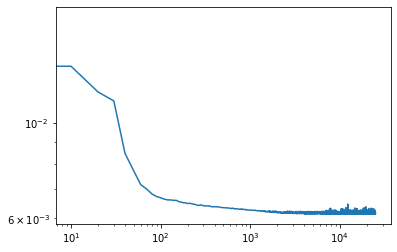

In [11]:
plt.loglog(
fac_mini.report.loss_history_ticks,
fac_mini.report.loss_history.min(axis=1)
)
plt.show()


In [8]:
open('graph_kernel_pic.pickle', 'wb').write(pickle.dumps(target))

262560

In [78]:
bs = 100
N = 256

In [73]:
gk_losses[1][:10]

[0.0060881,
 0.0042106,
 0.0027955,
 0.0024306,
 0.0018857,
 0.0013048,
 0.0010621,
 0.0008916,
 0.0007387,
 0.0006812]

In [54]:
errors

[0.0061358, 0.004226, 0.0027636, 0.0022452, 0.0015363, 0.0014056, 0.001082]

In [80]:
errors2

[0.0008162, 0.0007716, 0.0005482]

In [56]:
error = fac.report.loss_best
er = round(float(torch.min(error).cpu().detach().numpy()), 7)
print(er)

AttributeError: 'RBFExpansion' object has no attribute '_report'

In [19]:
open('graph_kernel_losses.pickle', 'wb').write(pickle.dumps(errors))

5454

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does n

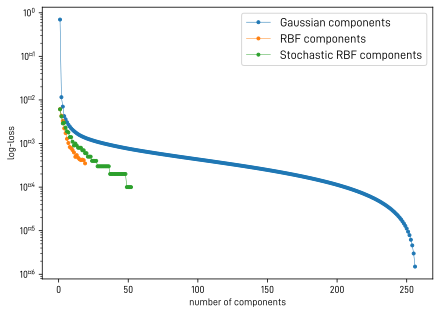

In [95]:
plt.figure(figsize=(7, 5))
plt.plot(range(1, target.shape[0]+1), s_vals, '.-', label='Gaussian components')
plt.plot(range(1, len(errors)+1), errors, '.-', label='RBF components')
plt.plot(range(1, len(rgb_sgd)+1), rgb_sgd, '.-', label='Stochastic RBF components')
plt.ylabel('log-loss')
plt.yscale('log')
plt.xlabel('number of components')
plt.legend(loc='upper right', fontsize=12)
#plt.title('Graph kernel 256*256')
plt.show()

In [8]:
def find_svd(X,s):
    U, S, V = np.linalg.svd(X.detach().numpy())
    return round(float(F.mse_loss(torch.tensor((U[:, :s] * S[None, :s]) @ V[:s, :]), X)), 7)

In [22]:
s_vals = []
for s in range(target.shape[0]):
    s_vals.append(find_svd(target, s))

In [15]:
len(s_vals)

256

In [11]:
open('graph_kernel_svd.pickle', 'wb').write(pickle.dumps(s_vals[1:]))

2311

In [47]:
errors

[0.0060881,
 0.0042106,
 0.0027955,
 0.0024306,
 0.0018857,
 0.0013048,
 0.0010621,
 0.0008916,
 0.0007387,
 0.0006812]

In [41]:
errors_mini

[0.0061804,
 0.0046355,
 0.0038087,
 0.0030982,
 0.0021956,
 0.0021081,
 0.0014806,
 0.0015258,
 0.0010862,
 0.0010517,
 0.0009961,
 0.0009438,
 0.0008429,
 0.0007509,
 0.0006723,
 0.0006414,
 0.0007446,
 0.0006746,
 0.0006916]

In [50]:
a

[0.0061,
 0.0042,
 0.0029,
 0.003,
 0.0023,
 0.0019,
 0.0018,
 0.0014,
 0.0014,
 0.0011,
 0.0009,
 0.001,
 0.0009,
 0.0008,
 0.0008,
 0.0008,
 0.0007,
 0.0007,
 0.0006,
 0.0006,
 0.0005,
 0.0005,
 0.0005,
 0.0004,
 0.0004,
 0.0004,
 0.0004,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0003,
 0.0002,
 0.0002,
 0.0002,
 0.0002,
 0.0002,
 0.0002,
 0.0002,
 0.0002,
 0.0002,
 0.0002,
 0.0002,
 0.0002,
 0.0001,
 0.0001,
 0.0001,
 0.0001]

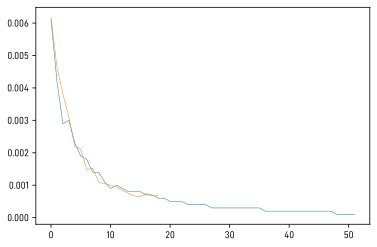

In [51]:
plt.plot(range(len(a)), a, range(len(errors_mini)), errors_mini)

In [49]:
a = pickle.load(open('graph_kernel_sgd_losses.pickle', "rb"))

In [69]:
times_mini = [63/60, 50/60, 52/60, 56/60, 50/60, 52/60, 58/60, 61/60, 64/60, 67/60]

In [70]:
times = [62/60, 98/60, 146/60, 169/60, 226/60, 250/60, 304/60, 310/60, 383/60, 413/60]

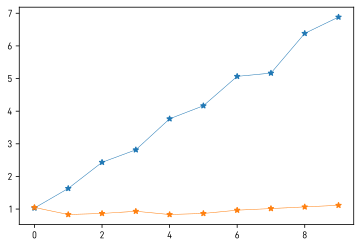

In [71]:
plt.plot(range(10), times,'*-' , range(10), times_mini,'*-' )

In [10]:
errors_mini_2

[0.0005691,
 0.0002283,
 0.0001303,
 0.0001106,
 0.000112,
 0.0001076,
 0.0001042,
 0.0001062]

In [11]:
 0.0006358,
 0.0002089,
 0.0001358,
 0.0001128,
 0.0001089,
 0.0001019,
 0.0001083,
 0.0001056

NameError: name 'errors_mini_1' is not defined

In [14]:
errors = [0.0060881,
 0.0042106,
 0.0027955,
 0.0024306,
 0.0018857,
 0.0013048,
 0.0010621,
 0.0008916,
 0.0007387,
 0.0006812]

In [16]:
s_vals = [0.6988124,
 0.0115783,
 0.0070272,
 0.0042515,
 0.0036036,
 0.0030903,
 0.0027092,
 0.0024542,
 0.0022272,
 0.0020658]

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does n

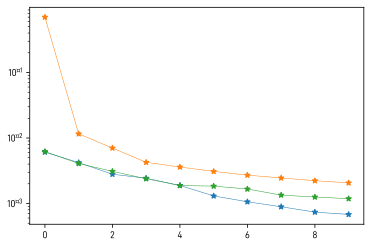

In [17]:
plt.plot(range(10), errors,'-*' , range(10), s_vals[:10], '*-' , range(10), errors_mini_2[:10],'*-' )
plt.yscale('log')

In [87]:
rgb_sgd =[0.0061,0.0042,0.0029,0.0030,0.0023,0.0019,0.0018,0.0014,0.0014,0.0011,0.0009,0.0010,0.0009,0.0008,0.0008,0.0008,0.0007,0.0007,0.0006,0.0006,0.0005,0.0005,0.0005, 0.0004, 0.0004,0.0004,0.0004,0.0003,0.0003,0.0003,0.0003,0.0003,0.0003,0.0003,0.0003,0.0003,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0002,0.0001, 0.0001, 0.0001, 0.0001]

In [88]:
len(rgb_sgd)

52

In [90]:
open('graph_kernel_sgd_losses.pickle', 'wb').write(pickle.dumps(rgb_sgd))

484

In [75]:
len(errors_mini)

19

In [74]:
errors_mini+errors_mini_1

[0.0061804,
 0.0046355,
 0.0038087,
 0.0030982,
 0.0021956,
 0.0021081,
 0.0014806,
 0.0015258,
 0.0010862,
 0.0010517,
 0.0009961,
 0.0009438,
 0.0008429,
 0.0007509,
 0.0006723,
 0.0006414,
 0.0007446,
 0.0006746,
 0.0006916,
 0.0006358,
 0.0002089,
 0.0001358,
 0.0001128,
 0.0001089,
 0.0001019,
 0.0001083,
 0.0001056]

In [19]:
ran = [1, 5, 10,15,20,40,60,80,100,120,140,160]

In [95]:
zz = errors_mini+errors_mini_1

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does n

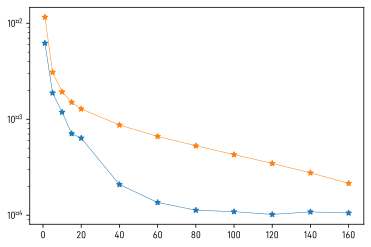

In [33]:
plt.plot(ran, aa,'-*', ran, [s_vals[t] for t in ran], '*-' )
plt.yscale('log')

In [34]:
open('gk_long_losses.pickle', 'wb').write(pickle.dumps([ran, aa, [s_vals[t] for t in ran]]))

268

In [36]:
open('gk_losses_2.pickle', 'wb').write(pickle.dumps([s_vals[1:11], errors, errors_mini_2]))

379

In [35]:
len(ran)

12

In [24]:
[s_vals[t] for t in ran]

[0.0115783,
 0.0030903,
 0.0019309,
 0.0015032,
 0.0012819,
 0.0008705,
 0.0006629,
 0.0005288,
 0.0004283,
 0.0003465,
 0.0002765,
 0.0002148]

In [29]:
aa = [errors_mini_2[0], errors_mini_2[4],errors_mini_2[9],errors_mini_2[14],0.0006358,
 0.0002089,
 0.0001358,
 0.0001128,
 0.0001089,
 0.0001019,
 0.0001083,
 0.0001056]

In [31]:
len(aa)

12